# Demographic Modeling for Boutique Fitness Site Selection
*Generated scaffold on* **2025-08-22**

This notebook implements the full data pipeline described in your assignment. Fill in API keys where indicated, then run each section top-to-bottom. Outputs:
- `data/otf_drive_time_stats.csv` — OTF-level 8‑minute stats
- `data/medical_professionals_by_city.csv` — city-level medical workforce share
- `data/city_scores.csv` — normalized scores & rankings


## 0. Environment & Config
Set your API keys here. The notebook supports either **Mapbox Isochrone API** or **OpenRouteService Isochrones** for 8‑minute drive-time polygons and the **Census API** for ACS variables.

**Required keys:**
- `MAPBOX_TOKEN` (or) `ORS_TOKEN`
- `CENSUS_KEY` (optional but recommended for higher rate limits)


In [ ]:
# ---- Config (EDIT THESE) ----
MAPBOX_TOKEN = "pk.eyJ1IjoibWFkZWxpbmVzd2FsbG93cyIsImEiOiJjbWVuNDEzYW4weXAzMmpwemd5bXpoOWJlIn0.mrMVptPzCWQmagy3kobsiQ"
ORS_TOKEN    = ""  # if using openrouteservice instead of Mapbox
CENSUS_KEY   = ""  # optional but recommended

# Runtime options
USE_MAPBOX = True   # set False to use OpenRouteService
ACS_VINTAGE = "2023"   # 5-year recommended for tract/block group stability
DRIVETIME_MIN = 8
OUTPUT_DIR = "data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

## 1. Orangetheory Locations
Scrape or load Orangetheory studio locations for the U.S. with address + lat/lon. Two supported paths:
1) **Direct scrape** of the public locations directory
2) **Import a CSV** you already have (`data/otf_locations_raw.csv`).

Expected schema after cleaning:
`otf_id, studio_name, address, city, state, zip, lat, lon`

In [3]:
!pip install requests pandas


In [14]:
# table of grid points

import pandas as pd

# Define bounding box for contiguous U.S.
lat_min, lat_max = 25, 49
lon_min, lon_max = -125, -66

# Create 1° resolution grid
grid_points = [(lat, lon) for lat in range(lat_min, lat_max + 1)
                        for lon in range(lon_min, lon_max + 1)]

grid_df = pd.DataFrame(grid_points, columns=["lat", "lon"])
print("Grid points count:", len(grid_df))
grid_df.head()


Grid points count: 1500


,lat,lon
0,25,-125
1,25,-124
2,25,-123
3,25,-122
4,25,-121


In [26]:
# found all orangetheory locations & saved in "orangetheory_studios.csv"

import requests
import pandas as pd

url = "https://api.gateway.orangetheory.com/v1/consumer-website/locations/search"

headers = {
    "Content-Type": "application/json",
    "User-Agent": "Mozilla/5.0"
}

studios = {}

# Rough bounding box for continental US
lat_min, lat_max = 25, 49
lng_min, lng_max = -125, -66

step = 1.0   # degrees between queries
radius = 50  # miles

for lat in range(lat_min, lat_max, int(step)):
    for lng in range(lng_min, lng_max, int(step)):
        payload = {
            "lat": lat,
            "lng": lng,
            "radius": radius,
            "filter": {"Country": "USA"},
            "favored_city": "USA"
        }
        try:
            resp = requests.post(url, json=payload, headers=headers, timeout=10)
            data = resp.json().get("items", [])
            for item in data:
                studios[item["id"]] = {
                    "id": item["id"],
                    "name": item["name"],
                    "status": item["status"],
                    "address": item["address"].get("address1", ""),
                    "city": item["address"].get("city", ""),
                    "state": item["address"].get("state", ""),
                    "postal_code": item["address"].get("postal_code", ""),
                    "latitude": item.get("latitude", ""),
                    "longitude": item.get("longitude", ""),
                    "phone": item.get("phone_number", "")
                }
        except Exception as e:
            print("Error at lat", lat, "lng", lng, ":", e)

# Save to CSV
df = pd.DataFrame(list(studios.values()))
df.to_csv("orangetheory_studios.csv", index=False)

print(f"Saved {len(df)} unique studios to orangetheory_studios.csv")


Saved 1405 unique studios to orangetheory_studios.csv


## 2. 8‑Minute Drive‑Time Isochrones
Generate an 8‑minute **driving** isochrone around each studio. Choose Mapbox or OpenRouteService via `USE_MAPBOX`.
Outputs a GeoJSON per studio under `data/isochrones/` and a combined layer for batch overlays.


In [27]:
# defined mapbox token & set isochrone variables
use_mapbox = True   # set to False to use ORS instead
mapbox_token = "pk.eyJ1IjoibWFkZWxpbmVzd2FsbG93cyIsImEiOiJjbWVuNDEzYW4weXAzMmpwemd5bXpoOWJlIn0.mrMVptPzCWQmagy3kobsiQ"

isochrone_minutes = 8
isochrone_seconds = isochrone_minutes * 60

In [32]:
import requests
import os
import geopandas as gpd
from shapely.geometry import shape

def get_mapbox_isochrone(lat, lon, minutes=8, profile="driving"):
    url = f"https://api.mapbox.com/isochrone/v1/mapbox/{profile}/{lon},{lat}"
    params = {
        "contours_minutes": minutes,
        "polygons": "true",
        "access_token": mapbox_token
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    geojson = r.json()
    return shape(geojson["features"][0]["geometry"])


In [39]:
import pandas as pd

df = pd.read_csv("/Users/madelineswallows/Downloads/Orange Theory Location Data/orangetheory_studios.csv")
print(df.head())

                                     id            name              status  \
0  eba7c1ae-6ecd-4f1f-9a5c-0fdc24fff083   Homestead, FL  PERMANENTLY_CLOSED   
1  6705a7e3-ae29-4af8-aace-3ffb85cd7fbb  Cutler Bay, FL                OPEN   
2  6d95a289-e7fe-4e14-b799-4b81507c65c8   Pinecrest, FL                OPEN   
3  fff3c51d-034a-49c7-b4cb-94622c8f0cd0         Mission                OPEN   
4  90181582-b80c-401f-9509-c38c31c2e7a9   Harlingen, TX                OPEN   

                           address        city    state  postal_code  \
0            803 N. Homestead Blvd   Homestead  Florida        33030   
1            18455 South Dixie Hwy  Cutler Bay  Florida        33157   
2             8511 SW 136th Street   Pinecrest  Florida        33156   
3             2700 W Expressway 83     McAllen    Texas        78503   
4  6710 W Expressway 83, Suite 104   Harlingen    Texas        78552   

    latitude  longitude       phone  
0  25.477970 -80.464241  7866327800  
1  25.597988 -80

In [40]:
import os
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape

# Mapbox token
MAPBOX_TOKEN = "pk.eyJ1IjoibWFkZWxpbmVzd2FsbG93cyIsImEiOiJjbWVuNDEzYW4weXAzMmpwemd5bXpoOWJlIn0.mrMVptPzCWQmagy3kobsiQ"

# Load your dataset
df = pd.read_csv("/Users/madelineswallows/Downloads/Orange Theory Location Data/orangetheory_studios.csv")
studios = df[["id", "latitude", "longitude"]].copy()
print(studios.head())


                                     id   latitude  longitude
0  eba7c1ae-6ecd-4f1f-9a5c-0fdc24fff083  25.477970 -80.464241
1  6705a7e3-ae29-4af8-aace-3ffb85cd7fbb  25.597988 -80.354370
2  6d95a289-e7fe-4e14-b799-4b81507c65c8  25.644012 -80.331337
3  fff3c51d-034a-49c7-b4cb-94622c8f0cd0  26.190001 -98.250000
4  90181582-b80c-401f-9509-c38c31c2e7a9  26.188232 -97.756327


In [41]:
os.makedirs("data/isochrones", exist_ok=True)

def get_isochrone(lat, lon, studio_id, cache_dir="data/isochrones"):
    cache_file = os.path.join(cache_dir, f"{studio_id}.geojson")
    if os.path.exists(cache_file):
        return gpd.read_file(cache_file)

    url = (
        f"https://api.mapbox.com/isochrone/v1/mapbox/driving/"
        f"{lon},{lat}?contours_minutes=8&polygons=true&access_token={MAPBOX_TOKEN}"
    )
    r = requests.get(url)
    r.raise_for_status()
    data = r.json()

    gdf = gpd.GeoDataFrame.from_features(data["features"])
    gdf.to_file(cache_file, driver="GeoJSON")
    return gdf


In [43]:
sample = studios.head(5)

for _, row in sample.iterrows():
    gdf = get_isochrone(row.latitude, row.longitude, row.id)
    gdf["studio_id"] = row.id
    print(f"✅ Got {row.id}")


✅ Got eba7c1ae-6ecd-4f1f-9a5c-0fdc24fff083
✅ Got 6705a7e3-ae29-4af8-aace-3ffb85cd7fbb
✅ Got 6d95a289-e7fe-4e14-b799-4b81507c65c8
✅ Got fff3c51d-034a-49c7-b4cb-94622c8f0cd0
✅ Got 90181582-b80c-401f-9509-c38c31c2e7a9


In [44]:
import os
import geopandas as gpd
import time

def get_isochrone(lat, lon, studio_id, cache_dir="data/isochrones"):
    """Fetch an 8-min isochrone for a studio, caching results."""
    os.makedirs(cache_dir, exist_ok=True)
    cache_file = os.path.join(cache_dir, f"{studio_id}.geojson")

    # If it’s already cached, load it instead of fetching again
    if os.path.exists(cache_file):
        return gpd.read_file(cache_file)

    url = (
        f"https://api.mapbox.com/isochrone/v1/mapbox/driving/"
        f"{lon},{lat}?contours_minutes=8&polygons=true&access_token={MAPBOX_TOKEN}"
    )

    try:
        r = requests.get(url, timeout=20)
        r.raise_for_status()
        with open(cache_file, "w") as f:
            f.write(r.text)  # save to disk
        return gpd.read_file(cache_file)

    except Exception as e:
        print(f"❌ Failed for {studio_id}: {e}")
        return None


# --- Loop over all studios, skipping already cached ones ---
all_isochrones = []

for _, row in studios.iterrows():
    cache_file = f"data/isochrones/{row.id}.geojson"

    if os.path.exists(cache_file):
        print(f"⏩ Skipping {row.id}, already cached")
        continue  # don’t fetch again

    gdf = get_isochrone(row.latitude, row.longitude, row.id)
    if gdf is not None:
        gdf["studio_id"] = row.id
        all_isochrones.append(gdf)
        print(f"✅ Got {row.id}")
    
    time.sleep(0.2)  # prevent rate-limit

# Save to a single GeoPackage at the end
if all_isochrones:
    merged = gpd.GeoDataFrame(pd.concat(all_isochrones, ignore_index=True))
    merged.to_file("data/otf_isochrones_8min.gpkg", driver="GPKG")
    print("🎉 All done! Saved to data/otf_isochrones_8min.gpkg")

⏩ Skipping eba7c1ae-6ecd-4f1f-9a5c-0fdc24fff083, already cached
⏩ Skipping 6705a7e3-ae29-4af8-aace-3ffb85cd7fbb, already cached
⏩ Skipping 6d95a289-e7fe-4e14-b799-4b81507c65c8, already cached
⏩ Skipping fff3c51d-034a-49c7-b4cb-94622c8f0cd0, already cached
⏩ Skipping 90181582-b80c-401f-9509-c38c31c2e7a9, already cached
⏩ Skipping 14f55a59-0c45-465d-80b1-6b82ce959ce2, already cached
⏩ Skipping ad886357-8516-4719-85c1-57563ebfbfef, already cached
⏩ Skipping 62a9cda1-398b-4ee7-964a-d08ac0f10caf, already cached
⏩ Skipping 27793b48-dd34-4e7d-9a66-3ce55c9b553f, already cached
⏩ Skipping 1fff2c97-d2be-4024-86e9-ad8ee366cc72, already cached
⏩ Skipping 1a2f2375-17ff-4c8c-a8f7-9d50d2b43501, already cached
⏩ Skipping 9615bacb-1b0a-4e0d-8ec6-2306a66d7608, already cached
⏩ Skipping cdb0b3f7-bcbc-4a59-a43c-a55bb9b82be9, already cached
⏩ Skipping f0874c0b-de20-4267-bff5-1d0356b8edfe, already cached
⏩ Skipping 2025027e-8a6d-4f75-bf84-70f34cb12ca1, already cached
⏩ Skipping d79d0e9b-f6f5-4efb-a2da-7917c

In [49]:
import geopandas as gpd

# Load the GeoPackage you already created
gdf = gpd.read_file("data/otf_isochrones_8min.gpkg")

# Save as GeoJSON
gdf.to_file("data/otf_isochrones_8min.geojson", driver="GeoJSON")

print("✅ Saved as data/otf_isochrones_8min.geojson")

✅ Saved as data/otf_isochrones_8min.geojson


In [45]:
import os
os.path.exists("data/otf_isochrones_8min.gpkg")

True

In [46]:
import geopandas as gpd

iso = gpd.read_file("data/otf_isochrones_8min.gpkg")
print(iso.head())


   fill-opacity fillColor  opacity     fill  fillOpacity    color  contour  \
0          0.33   #bf4040     0.33  #bf4040         0.33  #bf4040        8   
1          0.33   #bf4040     0.33  #bf4040         0.33  #bf4040        8   
2          0.33   #bf4040     0.33  #bf4040         0.33  #bf4040        8   
3          0.33   #bf4040     0.33  #bf4040         0.33  #bf4040        8   
4          0.33   #bf4040     0.33  #bf4040         0.33  #bf4040        8   

  metric                             studio_id  \
0   time  c37e66ff-c69b-4986-b10d-ff8124fd1ecb   
1   time  dd73eaa2-6a30-4f4f-ad8a-4cfeb2f9026a   
2   time  9f3bcf07-cdf0-47e1-90ea-5ff7bff0ee21   
3   time  1b9deb0b-5e65-4317-a256-3c92c72ca8dd   
4   time  9d788418-58c1-41e6-89d0-de4e724344d3   

                                            geometry  
0  POLYGON ((-80.32514 25.94911, -80.32614 25.948...  
1  POLYGON ((-80.38606 25.80587, -80.38634 25.790...  
2  POLYGON ((-80.31143 26.00926, -80.31201 26.008...  
3  POLYGON

In [ ]:
import math, json, os, pandas as pd
from pathlib import Path

ISO_DIR = Path(OUTPUT_DIR)/"isochrones"
ISO_DIR.mkdir(parents=True, exist_ok=True)

def mapbox_isochrone(lon, lat, minutes=8, profile="driving"):
    import requests
    url = f"https://api.mapbox.com/isochrone/v1/mapbox/{profile}/{lon},{lat}?contours_minutes={minutes}&polygons=true&dedupe=true&access_token={MAPBOX_TOKEN}"
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    return r.json()

def ors_isochrone(lon, lat, minutes=8, profile="driving-car"):
    import requests
    url = "https://api.openrouteservice.org/v2/isochrones/" + profile
    headers = {"Authorization": ORS_TOKEN, "Accept":"application/json"}
    payload = {
        "locations": [[lon, lat]],
        "range": [minutes*60],  # seconds
        "range_type": "time",
        "attributes": ["area","reachfactor"]
    }
    r = requests.post(url, json=payload, headers=headers, timeout=60)
    r.raise_for_status()
    return r.json()

def build_isochrones(df):
    all_features = []
    for i,row in df.iterrows():
        if pd.isna(row['lat']) or pd.isna(row['lon']):
            continue
        lon, lat = float(row['lon']), float(row['lat'])
        try:
            gj = mapbox_isochrone(lon, lat, DRIVETIME_MIN) if USE_MAPBOX else ors_isochrone(lon, lat, DRIVETIME_MIN)
            # Save per-studio
            fp = ISO_DIR / f"iso_{row['otf_id']}.geojson"
            with open(fp, 'w') as f:
                json.dump(gj, f)
            # Collect
            for feat in gj.get('features', []):
                feat['properties'] = dict(feat.get('properties', {}), otf_id=row['otf_id'])
                all_features.append(feat)
        except Exception as e:
            print(f"Isochrone failed for {row['otf_id']}: {e}")
    # Write combined
    combined = {"type":"FeatureCollection","features":all_features}
    with open(ISO_DIR/"isochrones_combined.geojson", 'w') as f:
        json.dump(combined, f)
    return ISO_DIR/"isochrones_combined.geojson"

# NOTE: Commented to avoid accidental API calls in this environment.
# combined_iso_path = build_isochrones(otf)
# print("Combined isochrones at:", combined_iso_path)

## 3. ACS Pulls (Population & Income)
We compute **Population** and **Average Household Income** within each isochrone by aggregating ACS at the block group or tract level (block groups recommended). We use:
- **Population**: `B01003_001E` (Total population)
- **Average household income**: derived as `B19025_001E / B11001_001E` (Aggregate household income / Total households). Alternatively, you may use median household income `B19013_001E`, but this notebook follows the *average* definition.

Steps:
1) Download ACS for all block groups nationwide (or by state batches).
2) Intersect polygons with isochrones and area-weight to aggregate.
3) Output per-OTF metrics.


In [47]:
pip install censusdata geopandas requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 5.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'censusdata' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'censusdata'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for censusdata: filename=censusdata-1.15.post1-py3-none-any.whl size=28205832 sha256=33641e503121381bad67b37134b4fa573cf78000eb58fcb974ce5aa9b2b1e8f5
  Stored in directory: /Users/madelineswallows/Library/Caches/pip/wheels/7c/5b/55/834c5472b44ab5688be29f6009667601fbc13f38cff9dd36e6
Successfully built censusdata
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests, zipfile, io, geopandas as gpd, pandas as pd
import censusdata, certifi, os

# Make sure folders exist
os.makedirs("data/tracts", exist_ok=True)

In [5]:
import requests, zipfile, io, geopandas as gpd
import urllib3

# Disable SSL warnings (since we're using verify=False)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

state_fips = "12"  # Florida
url = f"https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_{state_fips}_tract.zip"

# Download without verifying SSL
r = requests.get(url, verify=False)

# Extract shapefiles
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data/tracts")

# Load with GeoPandas
tracts = gpd.read_file("data/tracts/tl_2022_12_tract.shp")
print(tracts.head())


  STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  MTFCC  \
0      12      071  080203  12071080203  802.03  Census Tract 802.03  G5020   
1      12      071  040110  12071040110  401.10  Census Tract 401.10  G5020   
2      12      071  040124  12071040124  401.24  Census Tract 401.24  G5020   
3      12      011  060303  12011060303  603.03  Census Tract 603.03  G5020   
4      12      086  013600  12086013600     136     Census Tract 136  G5020   

  FUNCSTAT    ALAND   AWATER     INTPTLAT      INTPTLON  \
0        S  8741134  1791732  +26.4348430  -082.1105363   
1        S  7000293   337138  +26.6176111  -081.7900223   
2        S  6979169    32566  +26.6259190  -081.7339045   
3        S  1091219        0  +26.1580017  -080.2229792   
4        S   782295    29373  +25.8713902  -080.3262779   

                                            geometry  
0  POLYGON ((-82.14032 26.44849, -82.13991 26.449...  
1  POLYGON ((-81.80555 26.6238, -81.80554 26.6242...  
2  PO

In [6]:
import requests
import pandas as pd

# Census ACS 5-year API endpoint
base_url = "https://api.census.gov/data/2022/acs/acs5"

# Variables: population & median household income
variables = ["B01003_001E", "B19013_001E"]

# Build API request for all tracts in Florida
params = {
    "get": ",".join(["NAME"] + variables),
    "for": "tract:*",
    "in": "state:12"  # Florida
}

r = requests.get(base_url, params=params)
data = r.json()

# Convert to DataFrame
acs = pd.DataFrame(data[1:], columns=data[0])

# Convert numeric columns
acs["B01003_001E"] = pd.to_numeric(acs["B01003_001E"], errors="coerce")
acs["B19013_001E"] = pd.to_numeric(acs["B19013_001E"], errors="coerce")

print(acs.head())

                                         NAME  B01003_001E  B19013_001E state  \
0  Census Tract 2.01; Alachua County; Florida         4856        17727    12   
1  Census Tract 2.02; Alachua County; Florida         5464        13045    12   
2  Census Tract 3.01; Alachua County; Florida         4034        45227    12   
3  Census Tract 3.02; Alachua County; Florida         2363        41868    12   
4     Census Tract 4; Alachua County; Florida         5526        50417    12   

  county   tract  
0    001  000201  
1    001  000202  
2    001  000301  
3    001  000302  
4    001  000400  


In [9]:
import pandas as pd

df = pd.read_csv("/Users/madelineswallows/Downloads/Orange Theory Location Data/orangetheory_studios.csv")  # or whatever filename you used

states = df["state"].unique().tolist()  # change if it's "State"
print(states)

['Florida', 'Texas', 'Louisiana', 'Alabama', 'Mississippi', 'Georgia', 'California', 'Arizona', 'South Carolina', 'Arkansas', 'North Carolina', 'New Mexico', 'Oklahoma', 'Tennessee', 'Nevada', 'Utah', 'Missouri', 'Kentucky', 'Virginia', 'Kansas', 'Illinois', 'Indiana', 'West Virginia', 'Colorado', 'Ohio', 'Maryland', 'District of Columbia', 'Delaware', 'Pennsylvania', 'New Jersey', 'New York', 'Nebraska', 'Iowa', 'Connecticut', 'Oregon', 'Michigan', 'Massachusetts', 'Rhode Island', 'Idaho', 'Wyoming', 'South Dakota', 'Wisconsin', 'New Hampshire', 'Maine', 'Minnesota', 'Vermont', 'Washington', 'Montana', 'North Dakota']


In [37]:
import geopandas as gpd
import glob
import os
import pandas as pd

# Path to the folder where all state folders live
root_folder = "/Users/madelineswallows/Desktop/"

# Look for .shp files inside each tl_2022_*_tract folder
pattern = os.path.join(root_folder, "tl_2022_*_tract", "*.shp")
shapefile_paths = glob.glob(pattern)

print("Found", len(shapefile_paths), "shapefiles")
print(shapefile_paths[:5])  # show first few to confirm

# Read them all
gdf_list = []
for shp in shapefile_paths:
    print("Loading:", shp)
    g = gpd.read_file(shp)
    gdf_list.append(g)

# Merge into one GeoDataFrame
tracts_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs=gdf_list[0].crs)

print("Combined GeoDataFrame shape:", tracts_gdf.shape)
print(tracts_gdf.head())


Found 49 shapefiles
['/Users/madelineswallows/Desktop/tl_2022_27_tract/tl_2022_27_tract.shp', '/Users/madelineswallows/Desktop/tl_2022_46_tract/tl_2022_46_tract.shp', '/Users/madelineswallows/Desktop/tl_2022_01_tract/tl_2022_01_tract.shp', '/Users/madelineswallows/Desktop/tl_2022_44_tract/tl_2022_44_tract.shp', '/Users/madelineswallows/Desktop/tl_2022_18_tract/tl_2022_18_tract.shp']
Loading: /Users/madelineswallows/Desktop/tl_2022_27_tract/tl_2022_27_tract.shp
Loading: /Users/madelineswallows/Desktop/tl_2022_46_tract/tl_2022_46_tract.shp
Loading: /Users/madelineswallows/Desktop/tl_2022_01_tract/tl_2022_01_tract.shp
Loading: /Users/madelineswallows/Desktop/tl_2022_44_tract/tl_2022_44_tract.shp
Loading: /Users/madelineswallows/Desktop/tl_2022_18_tract/tl_2022_18_tract.shp
Loading: /Users/madelineswallows/Desktop/tl_2022_25_tract/tl_2022_25_tract.shp
Loading: /Users/madelineswallows/Desktop/tl_2022_21_tract/tl_2022_21_tract.shp
Loading: /Users/madelineswallows/Desktop/tl_2022_05_tract/tl_

In [43]:
# Save merged shapefile
tracts_gdf.to_file("merged_tracts.shp")


In [20]:
from census import Census
import us

# Replace with your actual key
CENSUS_KEY = "9fefa8096773f63aed7b43241cbe3e726a27d709"

c = Census(CENSUS_KEY)

In [51]:
all_data = []

for st in states:
    try:
        # look up the state object once per loop
        state_obj = us.states.lookup(st)

        # query ACS by state FIPS
        data = c.acs5.state_county_tract(
            ('NAME', 'B19013_001E', 'B01003_001E'),
            state_obj.fips,
            "*",
            "*"
        )

        print(f"Success for {st}, got {len(data)} tracts")

        for row in data:
            # correctly attach state name
            row["state"] = state_obj.name
            row["state_abbr"] = state_obj.abbr  # optional, but useful later
            all_data.append(row)

    except Exception as e:
        print(f"Error for {st}: {e}")

tracts_df = pd.DataFrame(all_data)

Success for Florida, got 5160 tracts
Success for Texas, got 6896 tracts
Success for Louisiana, got 1388 tracts
Success for Alabama, got 1437 tracts
Success for Mississippi, got 878 tracts
Success for Georgia, got 2796 tracts
Success for California, got 9129 tracts
Success for Arizona, got 1765 tracts
Success for South Carolina, got 1323 tracts
Success for Arkansas, got 823 tracts
Success for North Carolina, got 2672 tracts
Success for New Mexico, got 612 tracts
Success for Oklahoma, got 1205 tracts
Success for Tennessee, got 1701 tracts
Success for Nevada, got 779 tracts
Success for Utah, got 716 tracts
Success for Missouri, got 1654 tracts
Success for Kentucky, got 1306 tracts
Success for Virginia, got 2198 tracts
Success for Kansas, got 829 tracts
Success for Illinois, got 3265 tracts
Success for Indiana, got 1696 tracts
Success for West Virginia, got 546 tracts
Success for Colorado, got 1447 tracts
Success for Ohio, got 3168 tracts
Success for Maryland, got 1475 tracts
Error for DC:

In [52]:
tracts_df.to_csv("all_states_tracts.csv", index=False)

In [53]:
import pandas as pd
import geopandas as gpd

# Load tract shapefiles (the merged GeoDataFrame you already built)
tracts_gdf = gpd.read_file("merged_tracts.shp")

# Load ACS data
acs_df = pd.read_csv("all_states_tracts.csv")

# Ensure tract codes are zero-padded correctly
acs_df["state"] = acs_df["state"].astype(str).str.zfill(2)
acs_df["county"] = acs_df["county"].astype(str).str.zfill(3)
acs_df["tract"] = acs_df["tract"].astype(str).str.zfill(6)

# Build GEOID in ACS data
acs_df["GEOID"] = acs_df["state"] + acs_df["county"] + acs_df["tract"]

# Ensure GEOID is string in both
tracts_gdf["GEOID"] = tracts_gdf["GEOID"].astype(str)
acs_df["GEOID"] = acs_df["GEOID"].astype(str)

# Merge
tracts_merged = tracts_gdf.merge(
    acs_df[["GEOID", "B19013_001E", "B01003_001E"]], 
    on="GEOID", 
    how="left"
)

print("Merged shape:", tracts_merged.shape)
print(tracts_merged.head())

# Save out
tracts_merged.to_file("tracts_with_acs.shp")

tracts_merged.to_file("tracts_with_acs.gpkg", driver="GPKG")



Merged shape: (83777, 15)
  STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  MTFCC  \
0      27      037  060716  27037060716  607.16  Census Tract 607.16  G5020   
1      27      037  060717  27037060717  607.17  Census Tract 607.17  G5020   
2      27      037  060710  27037060710  607.10  Census Tract 607.10  G5020   
3      27      037  060711  27037060711  607.11  Census Tract 607.11  G5020   
4      27      037  060713  27037060713  607.13  Census Tract 607.13  G5020   

  FUNCSTAT     ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S   3782700  292715  +44.8242789  -093.1831132   
1        S  11752835  552732  +44.8465754  -093.1305462   
2        S  10213320  361502  +44.7779970  -093.3059622   
3        S   3573178   30615  +44.7582405  -093.2810093   
4        S   2839920   54332  +44.7607027  -093.2665016   

                                            geometry  B19013_001E  B01003_001E  
0  POLYGON ((-93.19843 44.82719, -93.19711 44.828...          N

/var/folders/h0/txx430j97hv_30478tzfnwph0000gn/T/ipykernel_92512/3184706266.py:33: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  tracts_merged.to_file("tracts_with_acs.shp")
/Users/madelineswallows/miniconda3/envs/otf/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'B19013_001E' to 'B19013_001'
  ogr_write(
/Users/madelineswallows/miniconda3/envs/otf/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'B01003_001E' to 'B01003_001'
  ogr_write(


In [54]:
import pandas as pd
import geopandas as gpd
import us  # don’t forget this import

# Load shapefile
tracts_gdf = gpd.read_file("merged_tracts.shp")

# Load ACS table
acs = pd.read_csv("all_states_tracts.csv")

# Ensure tract and county are strings before zero-padding
acs["state_fips"] = acs["state"].apply(lambda x: us.states.lookup(x).fips)
acs["county_fips"] = acs["county"].astype(str).str.zfill(3)   # always 3 digits
acs["tract_fips"] = acs["tract"].astype(str).str.zfill(6)     # always 6 digits

# Build GEOID (string concatenation)
acs["GEOID"] = acs["state_fips"] + acs["county_fips"] + acs["tract_fips"]

# Check
print(acs[["state","county","tract","GEOID"]].head())

# Merge on GEOID
tracts_merged = tracts_gdf.merge(
    acs,
    on="GEOID",
    how="left"
)

print("Merged shape:", tracts_merged.shape)
print(tracts_merged[["GEOID", "B19013_001E", "B01003_001E"]].head())

# Save as GeoPackage
tracts_merged.to_file("tracts_with_acs.gpkg", driver="GPKG")


     state  county  tract        GEOID
0  Florida       1    201  12001000201
1  Florida       1    202  12001000202
2  Florida       1    301  12001000301
3  Florida       1    302  12001000302
4  Florida       1    400  12001000400
Merged shape: (83777, 23)
         GEOID  B19013_001E  B01003_001E
0  27037060716     128929.0       4145.0
1  27037060717     110781.0       2423.0
2  27037060710      63425.0       4638.0
3  27037060711      61818.0       4406.0
4  27037060713     107813.0       3097.0


In [55]:
print("Shapefile GEOID example:", tracts_gdf["GEOID"].iloc[0], len(tracts_gdf["GEOID"].iloc[0]))
print("ACS GEOID example:", acs["GEOID"].iloc[0], len(acs["GEOID"].iloc[0]))


Shapefile GEOID example: 27037060716 11
ACS GEOID example: 12001000201 11


In [57]:
print(acs.columns)
print(acs[["GEOID"]].head(10))


Index(['NAME', 'B19013_001E', 'B01003_001E', 'state', 'county', 'tract',
       'state_abbr', 'state_fips', 'county_fips', 'tract_fips', 'GEOID'],
      dtype='object')
         GEOID
0  12001000201
1  12001000202
2  12001000301
3  12001000302
4  12001000400
5  12001000500
6  12001000600
7  12001000700
8  12001000806
9  12001000808


In [58]:
# Make sure both sides are string type
acs["GEOID"] = acs["GEOID"].astype(str)
tracts_gdf["GEOID"] = tracts_gdf["GEOID"].astype(str)

# Merge
tracts_merged = tracts_gdf.merge(acs, on="GEOID", how="left")

# Check results
print("Merged shape:", tracts_merged.shape)
print("Matched rows:", tracts_merged['B19013_001E'].notna().sum())
print("Unmatched rows:", tracts_merged['B19013_001E'].isna().sum())
print(tracts_merged[["GEOID","B19013_001E","B01003_001E"]].head())


Merged shape: (83777, 23)
Matched rows: 83556
Unmatched rows: 221
         GEOID  B19013_001E  B01003_001E
0  27037060716     128929.0       4145.0
1  27037060717     110781.0       2423.0
2  27037060710      63425.0       4638.0
3  27037060711      61818.0       4406.0
4  27037060713     107813.0       3097.0


In [59]:
# Drop tracts with no ACS match
tracts_clean = tracts_merged.dropna(subset=["B19013_001E", "B01003_001E"])

print("Final cleaned shape:", tracts_clean.shape)

# Save cleaned version
tracts_clean.to_file("tracts_with_acs_clean.gpkg", driver="GPKG")


Final cleaned shape: (83556, 23)


In [3]:
import geopandas as gpd

# Load ACS tracts with attributes
tracts = gpd.read_file("tracts_with_acs_clean.gpkg")

# Load your isochrones (should also be polygons with an ID for each site)
isochrones = gpd.read_file("isochrones.geojson")  # or .shp if that's what you have


In [4]:
# Reproject isochrones if needed
isochrones = isochrones.to_crs(tracts.crs)

print(tracts.crs)
print(isochrones.crs)

EPSG:4269
EPSG:4269


In [5]:
tracts_in_iso = gpd.sjoin(
    tracts,
    isochrones,
    how="inner",      # only keep tracts that intersect
    predicate="intersects"
)

In [6]:
tracts_in_iso = tracts_in_iso.copy()

# Clean missing ACS codes
tracts_in_iso.loc[tracts_in_iso["B19013_001E"] < 0, "B19013_001E"] = None  

# Weighted sum
tracts_in_iso["income_x_pop"] = tracts_in_iso["B19013_001E"] * tracts_in_iso["B01003_001E"]

iso_stats = (
    tracts_in_iso
    .groupby("iso_id")
    .agg(
        total_population=("B01003_001E", "sum"),
        weighted_income=("income_x_pop", "sum")
    )
    .reset_index()
)

# Divide safely
iso_stats["weighted_income"] = iso_stats["weighted_income"] / iso_stats["total_population"]


In [7]:
iso_stats.to_csv("isochrone_demographics.csv", index=False)

In [70]:
import geopandas as gpd
import pandas as pd

# Load isochrones (the polygons you made earlier)
isochrones_gdf = gpd.read_file("isochrones.geojson")  # or whatever file you saved them to

# Load demographics summary
iso_stats = pd.read_csv("isochrone_demographics.csv")

# Merge
iso_with_demo = isochrones_gdf.merge(iso_stats, on="iso_id", how="left")

# Save out for mapping
iso_with_demo.to_file("isochrones_with_demographics.gpkg", driver="GPKG")

In [48]:
# state by state loop

import geopandas as gpd
import pandas as pd
import glob
import os

# Load ACS data (all states combined)
acs = pd.read_csv("data/acs_all_states.csv")

# Load OTF isochrones
isochrones = gpd.read_file("data/otf_isochrones_8min.gpkg")

# Create output file
output_file = "data/otf_isochrone_demographics.csv"

# If the file exists, we'll append new results
if not os.path.exists(output_file):
    pd.DataFrame(columns=["isochrone_id", "population", "median_income"]).to_csv(output_file, index=False)

# Get all tract shapefiles
tract_files = glob.glob("data/tracts/tl_2022_*_tract.shp")

for f in tract_files:
    statefp = os.path.basename(f).split("_")[2]  # e.g. "12" for Florida
    print(f"Processing state {statefp}...")

    # Load tracts
    tracts = gpd.read_file(f)

    # Merge ACS for this state
    acs_state = acs[acs["state"] == statefp]
    tracts = tracts.merge(
        acs_state,
        left_on=["STATEFP", "COUNTYFP", "TRACTCE"],
        right_on=["state", "county", "tract"],
        how="inner"
    )

    # Ensure same CRS
    tracts = tracts.to_crs(isochrones.crs)

    # Intersect with isochrones
    joined = gpd.overlay(tracts, isochrones, how="intersection")

    # Aggregate demographics
    results = joined.groupby("isochrone_id").apply(
        lambda g: pd.Series({
            "population": g["B01003_001E"].sum(),
            "median_income": (g["B19013_001E"] * g["B01003_001E"]).sum() / g["B01003_001E"].sum()
        })
    ).reset_index()

    # Append to CSV
    results.to_csv(output_file, mode="a", header=False, index=False)

print("✅ Finished! Results saved to:", output_file)


FileNotFoundError: [Errno 2] No such file or directory: 'data/acs_all_states.csv'

In [12]:
!pip install census us

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [census]


In [22]:
import geopandas as gpd
import pandas as pd
import requests

all_isochrones = []

for idx, row in df.iterrows():
    lat, lon = row["latitude"], row["longitude"]

    try:
        # Example using Mapbox Isochrone API (adjust if you're using ORS or others)
        url = f"https://api.mapbox.com/isochrone/v1/mapbox/driving/{lon},{lat}"
        params = {
            "contours_minutes": 8,   # 8-minute drive
            "polygons": "true",
            "access_token": "pk.eyJ1IjoibWFkZWxpbmVzd2FsbG93cyIsImEiOiJjbWVuNDEzYW4weXAzMmpwemd5bXpoOWJlIn0.mrMVptPzCWQmagy3kobsiQ"
        }
        r = requests.get(url, params=params)
        r.raise_for_status()
        data = r.json()

        if "features" in data and len(data["features"]) > 0:
            feature = data["features"][0]

            # Attach IDs
            feature["properties"]["otf_id"] = row["id"]   # original Orangetheory ID
            feature["properties"]["iso_id"] = f"{row['id']}_8min"  # unique isochrone ID

            all_isochrones.append(feature)

        print(f"✅ Isochrone built for {row['city']}, {row['state']}")

    except Exception as e:
        print(f"❌ Error for {row['city']}, {row['state']}: {e}")

# Convert to GeoDataFrame
if all_isochrones:
    isochrones_gdf = gpd.GeoDataFrame.from_features(all_isochrones, crs="EPSG:4326")
    isochrones_gdf.to_file("isochrones.geojson", driver="GeoJSON")
    print(f"Saved {len(isochrones_gdf)} isochrones to isochrones.geojson")
else:
    print("No isochrones generated.")


✅ Isochrone built for Homestead, Florida
✅ Isochrone built for Cutler Bay, Florida
✅ Isochrone built for Pinecrest, Florida
✅ Isochrone built for McAllen, Texas
✅ Isochrone built for Harlingen, Texas
✅ Isochrone built for McAllen, Texas
✅ Isochrone built for Brownsville, Texas
✅ Isochrone built for NAPLES, Florida
✅ Isochrone built for Naples, Florida
✅ Isochrone built for Estero, Florida
✅ Isochrone built for Fort Myers, Florida
✅ Isochrone built for Cape Coral, Florida
✅ Isochrone built for Fort Myers, Florida
✅ Isochrone built for Weston, Florida
✅ Isochrone built for Pembroke Pines, Florida
✅ Isochrone built for Miami, Florida
✅ Isochrone built for Doral, Florida
✅ Isochrone built for Miami Lakes, Florida
✅ Isochrone built for Miami, Florida
✅ Isochrone built for Miramar, Florida
✅ Isochrone built for Cooper City, Florida
✅ Isochrone built for Miami, Florida
✅ Isochrone built for Sunrise, Florida
✅ Isochrone built for Plantation, Florida
✅ Isochrone built for Miami, Florida
✅ Isoch

In [18]:
import geopandas as gpd
import pandas as pd

# ACS variables already pulled into your tracts dataset:
#   pop         = total population (B01003_001E)
#   med_hh_inc  = median household income (B19013_001E)


In [ ]:
# Load all tracts (already downloaded + merged)
tracts = gpd.read_file("data/tracts_all_states.gpkg")

# Load isochrones (8-minute drive times for each OTF location)
isochrones = gpd.read_file("data/otf_isochrones_8min.gpkg")

In [ ]:
import geopandas as gpd
from shapely.geometry import shape
import pandas as pd, requests, io, zipfile, json, math

def fetch_acs_block_groups(state_fips, vintage="2023", census_key=None):
    # Pull selected variables for all block groups in a state
    vars = ["B01003_001E","B19025_001E","B11001_001E","NAME","state","county","tract","block group"]
    var_str = ",".join(vars)
    key = f"&key={census_key}" if census_key else ""
    url = (f"https://api.census.gov/data/{vintage}/acs/acs5?get={var_str}&for=block%20group:*&in=state:{state_fips}{key}")
    r = requests.get(url, timeout=120)
    r.raise_for_status()
    data = r.json()
    df = pd.DataFrame(data[1:], columns=data[0])
    # Cast numeric
    for c in ["B01003_001E","B19025_001E","B11001_001E"]:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

# TIGER geometries for block groups; user must download externally or use census TIGERweb
# This stub assumes you have a GeoPackage with geometries in data/tiger_blockgroups.gpkg
def load_block_groups_gpkg():
    gpkg = Path(OUTPUT_DIR)/"tiger_blockgroups.gpkg"
    if not gpkg.exists():
        raise FileNotFoundError("Missing data/tiger_blockgroups.gpkg. See README for download instructions.")
    return gpd.read_file(gpkg, layer='blockgroups').to_crs(4326)

def aggregate_within_isochrones(otf_df):
    # Load geometries
    bgs = load_block_groups_gpkg()
    # Join ACS attributes (user populates separately)
    attr_csv = Path(OUTPUT_DIR)/"acs_blockgroups.csv"
    if not attr_csv.exists():
        raise FileNotFoundError("Missing data/acs_blockgroups.csv. Pull ACS first.")
    attrs = pd.read_csv(attr_csv)
    bgs = bgs.merge(attrs, on=['STATEFP','COUNTYFP','TRACTCE','BLKGRPCE'], how='left')
    # Load combined isochrones
    iso = gpd.read_file(Path(OUTPUT_DIR)/"isochrones/isochrones_combined.geojson").to_crs(4326)
    out_rows = []
    for otf_id, group in iso.groupby('otf_id'):
        poly = group.iloc[0].geometry
        sub = gpd.overlay(bgs, gpd.GeoDataFrame(geometry=[poly], crs=4326), how='intersection')
        # Area weights
        sub['w'] = sub.geometry.area / bgs.loc[bgs.index.isin(sub.index),'geometry'].area.values
        pop = (sub['B01003_001E']*sub['w']).sum()
        agg_income = (sub['B19025_001E']*sub['w']).sum()
        hh = (sub['B11001_001E']*sub['w']).sum()
        avg_hh_income = agg_income / hh if hh > 0 else None
        city = otf_df.loc[otf_df['otf_id']==otf_id, 'city'].iloc[0] if otf_id in set(otf_df['otf_id']) else None
        out_rows.append(dict(otf_id=otf_id, city=city, population_8min=int(round(pop)), income_avg_8min=avg_hh_income))
    out = pd.DataFrame(out_rows)
    out.to_csv(Path(OUTPUT_DIR)/"otf_drive_time_stats.csv", index=False)
    return out

# NOTE: Heavy operations (downloading TIGER, ACS) are left for the user environment.
# display(aggregate_within_isochrones(otf))

## 4. Medical Professionals (% by City)
We calculate the percent of **medical professionals** in the labor force at the **city** level using ACS **S2401** (Occupation by Sex). Use the categories:
- *Healthcare practitioners and technical occupations*
- *Healthcare support occupations*
Percent = (practitioners + support) / employed civilian population 16+.
You can pull via the Census API and roll up by **place (city)** GEOID.


In [77]:
# --- 1. Setup ---
import pandas as pd
import requests

# Load Orangetheory locations
otf = pd.read_csv("/Users/madelineswallows/Downloads/Orange Theory Location Data/orangetheory_studios.csv")

# Preview
print(otf.head())


                                     id            name              status  \
0  eba7c1ae-6ecd-4f1f-9a5c-0fdc24fff083   Homestead, FL  PERMANENTLY_CLOSED   
1  6705a7e3-ae29-4af8-aace-3ffb85cd7fbb  Cutler Bay, FL                OPEN   
2  6d95a289-e7fe-4e14-b799-4b81507c65c8   Pinecrest, FL                OPEN   
3  fff3c51d-034a-49c7-b4cb-94622c8f0cd0         Mission                OPEN   
4  90181582-b80c-401f-9509-c38c31c2e7a9   Harlingen, TX                OPEN   

                           address        city    state  postal_code  \
0            803 N. Homestead Blvd   Homestead  Florida        33030   
1            18455 South Dixie Hwy  Cutler Bay  Florida        33157   
2             8511 SW 136th Street   Pinecrest  Florida        33156   
3             2700 W Expressway 83     McAllen    Texas        78503   
4  6710 W Expressway 83, Suite 104   Harlingen    Texas        78552   

    latitude  longitude       phone  
0  25.477970 -80.464241  7866327800  
1  25.597988 -80

In [88]:
import pandas as pd

# 👇 Change this to where your TXT file is
gaz_file = "/Users/madelineswallows/Downloads/2023_Gaz_place_national.txt"

# Read the Gazetteer Places TXT
gaz = pd.read_csv(gaz_file, sep="\t", dtype=str)

# Preview first few rows
display(gaz.head())


,USPS,GEOID,ANSICODE,NAME,LSAD,FUNCSTAT,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,AL,0100100,02582661,Abanda CDP,57,S,7764034,34284,2.998,0.013,33.091627,-85.527029 ...
1,AL,0100124,02403054,Abbeville city,25,A,40255361,107642,15.543,0.042,31.564706,-85.259121 ...
2,AL,0100460,02403063,Adamsville city,25,A,67897213,540470,26.215,0.209,33.602315,-86.971527 ...
3,AL,0100484,02405123,Addison town,43,A,9753293,83417,3.766,0.032,34.202681,-87.178004 ...
4,AL,0100676,02405125,Akron town,43,A,1776165,13849,0.686,0.005,32.879066,-87.740899 ...


In [2]:
import pandas as pd
from thefuzz import process
from tqdm.notebook import tqdm   # progress bar for Jupyter

# Load OTF
otf = pd.read_csv("/Users/madelineswallows/Downloads/Orange Theory Location Data/orangetheory_studios.csv")

# Load Gazetteer
gaz_file = "/Users/madelineswallows/Downloads/2023_Gaz_place_national.txt"
gaz = pd.read_csv(gaz_file, sep="\t", dtype=str)
gaz = gaz[["GEOID", "NAME", "USPS"]].copy()
gaz.rename(columns={"NAME": "place_name", "USPS": "state"}, inplace=True)

# State abbreviation map
state_abbrev = {
    "Alabama":"AL","Alaska":"AK","Arizona":"AZ","Arkansas":"AR","California":"CA",
    "Colorado":"CO","Connecticut":"CT","Delaware":"DE","District of Columbia":"DC",
    "Florida":"FL","Georgia":"GA","Hawaii":"HI","Idaho":"ID","Illinois":"IL",
    "Indiana":"IN","Iowa":"IA","Kansas":"KS","Kentucky":"KY","Louisiana":"LA",
    "Maine":"ME","Maryland":"MD","Massachusetts":"MA","Michigan":"MI","Minnesota":"MN",
    "Mississippi":"MS","Missouri":"MO","Montana":"MT","Nebraska":"NE","Nevada":"NV",
    "New Hampshire":"NH","New Jersey":"NJ","New Mexico":"NM","New York":"NY",
    "North Carolina":"NC","North Dakota":"ND","Ohio":"OH","Oklahoma":"OK","Oregon":"OR",
    "Pennsylvania":"PA","Rhode Island":"RI","South Carolina":"SC","South Dakota":"SD",
    "Tennessee":"TN","Texas":"TX","Utah":"UT","Vermont":"VT","Virginia":"VA",
    "Washington":"WA","West Virginia":"WV","Wisconsin":"WI","Wyoming":"WY"
}

# Normalize OTF
otf["city"] = otf["city"].str.strip()
otf["state"] = otf["state"].map(state_abbrev).fillna(otf["state"])

# --- Caching setup ---
cache = {}

# Fuzzy match function with caching
def best_match(city, state, gaz, threshold=85):
    key = (city.lower(), state)
    if key in cache:
        return cache[key]

    subset = gaz[gaz["state"] == state]
    if subset.empty:
        cache[key] = (None, None)
        return cache[key]

    result = process.extractOne(city, subset["place_name"])
    if result is None:
        cache[key] = (None, None)
        return cache[key]
    
    match, score, _ = result
    if score >= threshold:
        row = subset[subset["place_name"] == match].iloc[0]
        cache[key] = (row["GEOID"], match)
    else:
        cache[key] = (None, None)

    return cache[key]

# Apply with tqdm progress bar
tqdm.pandas()
matches = otf.progress_apply(lambda r: best_match(r["city"], r["state"], gaz), axis=1)

otf[["GEOID", "matched_place"]] = pd.DataFrame(matches.tolist(), index=otf.index)

# Results
display(otf.head())
print("Matched:", otf['GEOID'].notna().sum())
print("Unmatched:", otf['GEOID'].isna().sum())
print("Unique lookups performed:", len(cache))


  0%|          | 0/1405 [00:00<?, ?it/s]

,id,name,status,address,city,state,postal_code,latitude,longitude,phone,GEOID,matched_place
0,eba7c1ae-6ecd-4f1f-9a5c-0fdc24fff083,"Homestead, FL",PERMANENTLY_CLOSED,803 N. Homestead Blvd,Homestead,FL,33030,25.477970,-80.464241,7866327800,1232275,Homestead city
1,6705a7e3-ae29-4af8-aace-3ffb85cd7fbb,"Cutler Bay, FL",OPEN,18455 South Dixie Hwy,Cutler Bay,FL,33157,25.597988,-80.354370,3052341141,1215968,Cutler Bay town
2,6d95a289-e7fe-4e14-b799-4b81507c65c8,"Pinecrest, FL",OPEN,8511 SW 136th Street,Pinecrest,FL,33156,25.644012,-80.331337,3052327722,1256625,Pinecrest village
3,fff3c51d-034a-49c7-b4cb-94622c8f0cd0,Mission,OPEN,2700 W Expressway 83,McAllen,TX,78503,26.190001,-98.250000,9563774737,4845384,McAllen city
4,90181582-b80c-401f-9509-c38c31c2e7a9,"Harlingen, TX",OPEN,"6710 W Expressway 83, Suite 104",Harlingen,TX,78552,26.188232,-97.756327,9567523470,4832372,Harlingen city


Matched: 1322
Unmatched: 83
Unique lookups performed: 1016


In [3]:
import requests
import pandas as pd

# Your Census API key
API_KEY = "9fefa8096773f63aed7b43241cbe3e726a27d709"

# Example: get medical professionals + total pop for all places
def get_census_data(geoids):
    results = []
    for geoid in geoids:
        # Occupation data (ACS 5-year, table C24030)
        occ_url = f"https://api.census.gov/data/2022/acs/acs5/subject"
        occ_params = {
            "get": "S2401_C01_001E,S2401_C01_007E,S2401_C01_008E",  # total employed, diagnosing/treating practitioners, technologists/techs
            "for": f"place:{geoid[-5:]}",  # last 5 digits = place code
            "in": f"state:{geoid[:2]}",
            "key": API_KEY
        }
        occ_resp = requests.get(occ_url, params=occ_params).json()

        # Population data (ACS table B01003)
        pop_url = f"https://api.census.gov/data/2022/acs/acs5"
        pop_params = {
            "get": "B01003_001E",  # total population
            "for": f"place:{geoid[-5:]}",
            "in": f"state:{geoid[:2]}",
            "key": API_KEY
        }
        pop_resp = requests.get(pop_url, params=pop_params).json()

        try:
            occ_data = occ_resp[1]  # skip header
            pop_data = pop_resp[1]
            results.append({
                "GEOID": geoid,
                "total_employed": int(occ_data[0]),
                "practitioners": int(occ_data[1]),
                "technologists": int(occ_data[2]),
                "total_population": int(pop_data[0])
            })
        except Exception as e:
            print("Error for GEOID", geoid, e)

    return pd.DataFrame(results)

# Example run: pull for first 5 OTF cities
geoids = otf["GEOID"].dropna().unique()[:5]
census_data = get_census_data(geoids)

# Compute % medical professionals
census_data["pct_medical_professionals"] = (
    (census_data["practitioners"] + census_data["technologists"]) / census_data["total_population"] * 100
)

display(census_data.head())


,GEOID,total_employed,practitioners,technologists,total_population,pct_medical_professionals
0,1232275,35090,533,273,79996,1.007550
1,1215968,23032,448,310,44738,1.694309
2,1256625,8034,152,113,18279,1.449751
3,4845384,63256,818,734,142722,1.087429
4,4832372,29183,445,170,71497,0.860176


In [9]:
import requests
import pandas as pd
import time

API_KEY = "9fefa8096773f63aed7b43241cbe3e726a27d709"

def get_census_data(geoids):
    results = []
    for geoid in geoids:
        state = geoid[:2]
        place = geoid[-5:]

        # --- Occupation data ---
        occ_url = "https://api.census.gov/data/2022/acs/acs5/subject"
        occ_params = {
            "get": "S2401_C01_001E,S2401_C01_007E,S2401_C01_008E",
            "for": f"place:{place}",
            "in": f"state:{state}",
            "key": API_KEY
        }
        occ_resp = requests.get(occ_url, params=occ_params)
        if occ_resp.status_code != 200:
            print(f"Occupation request failed for {geoid} ({occ_resp.status_code})")
            continue
        try:
            occ_data = occ_resp.json()
        except Exception:
            print(f"Bad occupation JSON for {geoid}: {occ_resp.text[:100]}")
            continue

        # --- Population data ---
        pop_url = "https://api.census.gov/data/2022/acs/acs5"
        pop_params = {
            "get": "B01003_001E",
            "for": f"place:{place}",
            "in": f"state:{state}",
            "key": API_KEY
        }
        pop_resp = requests.get(pop_url, params=pop_params)
        if pop_resp.status_code != 200:
            print(f"Population request failed for {geoid} ({pop_resp.status_code})")
            continue
        try:
            pop_data = pop_resp.json()
        except Exception:
            print(f"Bad population JSON for {geoid}: {pop_resp.text[:100]}")
            continue

        try:
            occ_row = occ_data[1]  # skip header
            pop_row = pop_data[1]
            results.append({
                "GEOID": geoid,
                "total_employed": int(occ_row[0]),
                "practitioners": int(occ_row[1]),
                "technologists": int(occ_row[2]),
                "total_population": int(pop_row[0])
            })
        except Exception as e:
            print(f"Parse error for {geoid}: {e}")

        time.sleep(0.2)  # polite delay

    return pd.DataFrame(results)

geoids = otf["GEOID"].dropna().unique().tolist()
print(f"Fetching Census data for {len(geoids)} places...")
census_data = get_census_data(geoids)

# Compute % medical professionals
census_data["pct_medical_professionals"] = (
    (census_data["practitioners"] + census_data["technologists"]) /
    census_data["total_population"] * 100
)

print("Finished:", census_data.shape)
census_data.head()

otf_with_metrics = otf.merge(census_data, on="GEOID", how="left")
otf_with_metrics.to_csv("otf_with_demographics.csv", index=False)
print("Saved as otf_with_demographics.csv")


Fetching Census data for 937 places...
Occupation request failed for 2148000 (204)
Finished: (936, 6)
Saved as otf_with_demographics.csv


In [ ]:
# saved results into "otf_with_demographics.csv"

## 5. Income Participation Curve & Scoring
Design a **nonlinear** mapping from average household income → estimated boutique fitness participation.
Anchors:
- $60,000 → ~8%
- $150,000 → ~25%

We use a **logistic function**:  
`p(income) = L / (1 + exp(-k*(income - x0))) + floor`  
Parameters are chosen to meet the anchors and cap reasonable participation (e.g., 3%–30%).
Final city score: `city_score = population_8min * p(income_avg_8min)`.
We then **normalize** scores to 0–100 across cities for ranking.


In [ ]:
import numpy as np, pandas as pd

# Logistic curve with floor/ceiling controls
def income_to_participation(income, p_floor=0.03, p_ceil=0.30, p_at_60k=0.08, p_at_150k=0.25):
    # Solve for logistic params given two anchor points.
    # Logistic core ranges from 0..1; scale to (p_floor..p_ceil)
    # f(x) = 1/(1+exp(-k*(x-x0)))
    # We'll solve k, x0 to satisfy scaled f(60k)=p_at_60k and f(150k)=p_at_150k.
    y1 = (p_at_60k - p_floor) / (p_ceil - p_floor)
    y2 = (p_at_150k - p_floor) / (p_ceil - p_floor)
    x1, x2 = 60000.0, 150000.0
    # Avoid domain issues
    y1 = np.clip(y1, 1e-6, 1-1e-6)
    y2 = np.clip(y2, 1e-6, 1-1e-6)
    # From y = 1/(1+e^{-k(x-x0)}), rearrange to logit(y) = k(x-x0)
    def logit(y): return np.log(y/(1-y))
    L1, L2 = logit(y1), logit(y2)
    k = (L2 - L1) / (x2 - x1)
    x0 = x1 - L1 / k
    def f(x):
        core = 1.0/(1.0+np.exp(-k*(np.array(x) - x0)))
        return p_floor + (p_ceil - p_floor)*core
    return f(income)

# Example curve values (not executed here)
# xs = np.linspace(20000, 250000, 200)
# ys = income_to_participation(xs)
# import matplotlib.pyplot as plt
# plt.plot(xs, ys); plt.xlabel('Average HH income'); plt.ylabel('Participation rate'); plt.show()

### Scoring & Normalization

In [ ]:
import pandas as pd, numpy as np
from pathlib import Path

def score_and_rank():
    fp = Path(OUTPUT_DIR)/"otf_drive_time_stats.csv"
    if not fp.exists():
        raise FileNotFoundError("Run the aggregation step to create otf_drive_time_stats.csv first.")
    df = pd.read_csv(fp)
    df['income_participation_factor'] = income_to_participation(df['income_avg_8min'])
    df['raw_score'] = df['population_8min'] * df['income_participation_factor']
    # Normalize to 0..100
    mn, mx = df['raw_score'].min(), df['raw_score'].max()
    df['city_score_norm'] = 100*(df['raw_score']-mn)/(mx-mn) if mx>mn else 50.0
    df.sort_values('city_score_norm', ascending=False, inplace=True)
    df.to_csv(Path(OUTPUT_DIR)/"city_scores.csv", index=False)
    return df[['otf_id','city','population_8min','income_avg_8min','income_participation_factor','city_score_norm']]

# ranked = score_and_rank()
# display(ranked.head(20))

## 6. Provenance Notes
- Orangetheory locations: scraped from public directory or licensed dataset.
- Isochrones: Mapbox Isochrone API or OpenRouteService Isochrones.
- ACS variables: population `B01003_001E`; aggregate household income `B19025_001E`; total households `B11001_001E`; occupation shares from `S2401`.
- Geometry: TIGER/Line Block Groups.
- All steps are reproducible with keys + data stored under `data/`.


Rows: 83556
Columns: Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME_x', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'NAME_y', 'B19013_001E', 'B01003_001E', 'state', 'county', 'tract',
       'state_abbr', 'state_fips', 'county_fips', 'tract_fips', 'geometry'],
      dtype='object')
  STATEFP COUNTYFP TRACTCE        GEOID  NAME_x             NAMELSAD  MTFCC  \
0      27      037  060716  27037060716  607.16  Census Tract 607.16  G5020   
1      27      037  060717  27037060717  607.17  Census Tract 607.17  G5020   
2      27      037  060710  27037060710  607.10  Census Tract 607.10  G5020   
3      27      037  060711  27037060711  607.11  Census Tract 607.11  G5020   
4      27      037  060713  27037060713  607.13  Census Tract 607.13  G5020   

  FUNCSTAT     ALAND  AWATER  ... B19013_001E B01003_001E      state  county  \
0        S   3782700  292715  ...    128929.0      4145.0  Minnesota    37.0   
1        S  11752835  55273

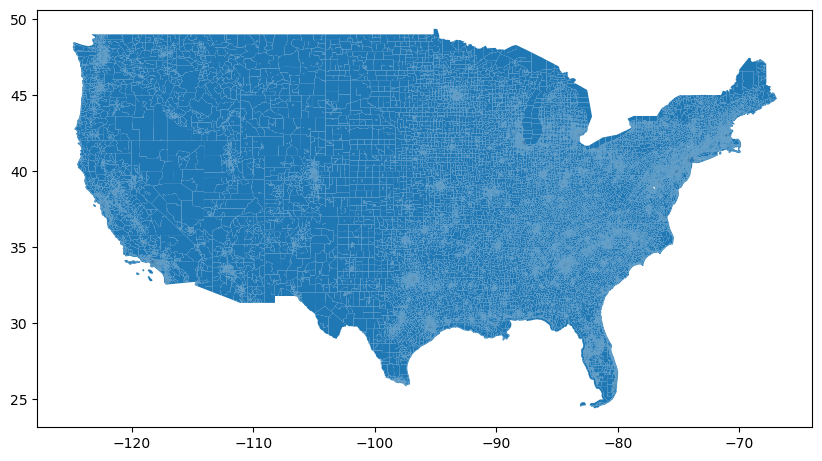

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your GeoPackage
gdf = gpd.read_file("tracts_with_acs_clean.gpkg")

print("Rows:", len(gdf))
print("Columns:", gdf.columns)

# Peek at first few rows
print(gdf.head())

# Plot just the geometries
gdf.plot(figsize=(10, 10))
plt.show()


<Axes: >

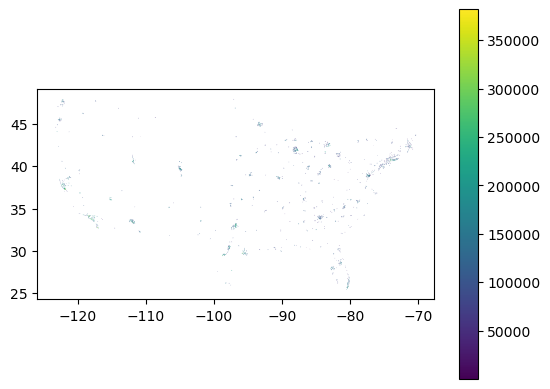

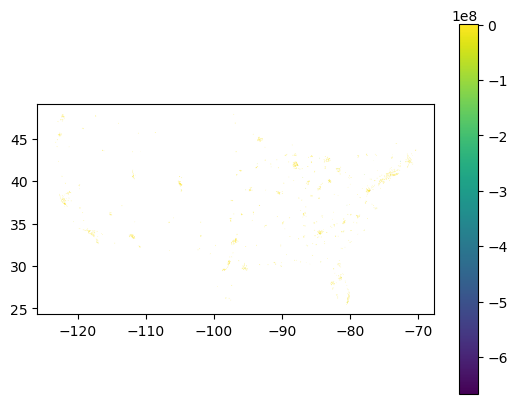

In [75]:
iso_with_demo.plot(column="total_population", legend=True)
iso_with_demo.plot(column="weighted_income", legend=True)


In [16]:
# Load your file
df = pd.read_csv("/Users/madelineswallows/Downloads/Orange Theory Location Data/orangetheory_studios.csv")

# Remove commas from text columns that might cause issues
df["name"] = df["name"].str.replace(",", "", regex=False)
df["address"] = df["address"].str.replace(",", "", regex=False)
df["city"] = df["city"].str.replace(",", "", regex=False)
df["state"] = df["state"].str.replace(",", "", regex=False)

# Save to a new CSV, safe for MySQL
df.to_csv("orangetheory_studios_mysql.csv", index=False, encoding="utf-8")


In [20]:
with open("/Users/madelineswallows/Downloads/orangetheory_studios_no_phone.csv", "r", encoding="utf-8") as f:
    for i, line in enumerate(f, 1):
        if line.count(",") != 9:  # expecting 10 columns → 9 commas
            print("Bad row at line", i, ":", line)


Bad row at line 1 : id,name,status,address,city,state,postal_code,latitude,longitude

Bad row at line 2 : eba7c1ae-6ecd-4f1f-9a5c-0fdc24fff083,Homestead FL,PERMANENTLY_CLOSED,803 N. Homestead Blvd,Homestead,Florida,33030,25.47797012,-80.46424103

Bad row at line 3 : 6705a7e3-ae29-4af8-aace-3ffb85cd7fbb,Cutler Bay FL,OPEN,18455 South Dixie Hwy,Cutler Bay,Florida,33157,25.59798813,-80.35437012

Bad row at line 4 : 6d95a289-e7fe-4e14-b799-4b81507c65c8,Pinecrest FL,OPEN,8511 SW 136th Street,Pinecrest,Florida,33156,25.64401245,-80.33133698

Bad row at line 5 : fff3c51d-034a-49c7-b4cb-94622c8f0cd0,Mission,OPEN,2700 W Expressway 83,McAllen,Texas,78503,26.19000053,-98.25

Bad row at line 6 : 90181582-b80c-401f-9509-c38c31c2e7a9,Harlingen TX,OPEN,6710 W Expressway 83 Suite 104,Harlingen,Texas,78552,26.188232,-97.756327

Bad row at line 7 : 14f55a59-0c45-465d-80b1-6b82ce959ce2,McAllen TX,OPEN,5800 N 10th St. suite 110,McAllen,Texas,78504,26.25548363,-98.22018433

Bad row at line 8 : ad886357-851